In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

In [2]:
valid=pd.read_csv('C:\\Users\\andre\\Documents\\test.csv',na_values=[' '])
dataset=pd.read_csv('C:\\Users\\andre\\Documents\\train.csv',na_values=[' '])

In [54]:
dataset.head()

,feature1,age,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,target
0,0.001963,42,0,0.079941,1350.0,7,0,0,0,0.0,0
1,0.004538,86,0,3.000000,NaN,2,0,0,0,NaN,0
2,0.023044,61,0,0.419916,5000.0,18,0,2,0,1.0,0
3,0.121242,48,0,0.526589,2500.0,12,0,1,0,1.0,0
4,1.000000,49,3,0.256567,5900.0,3,3,1,1,2.0,1


for i in range(len(dataset)):
    if dataset.ix[i]['age']<50:
        dataset.ix[i]['category_age']=0
    elif 50<=dataset.ix[i]['age']<70:
        dataset.ix[i]['category_age']=1
    if 90<=dataset.ix[i]['age']<90:
        dataset.ix[i]['category_age']=2

# Анализируем наши данные при помощи pandas profiling


In [19]:
profile = pp.ProfileReport(dataset)

In [20]:
profile

Number of variables,11
Number of observations,73276
Total Missing (%),2.0%
Total size in memory,6.1 MiB
Average record size in memory,88.0 B
Numeric,10
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


# видим что  feature3, feature7, feature9 почти не коррелируют с target. делаем гипотезу о том что они почти не влияют на качество модели


In [4]:
X=dataset.drop(['target'],axis=1)
y=dataset['target']

In [4]:
#categoricals = ['feature2','feature6','feature7','feature8','feature9']
#for i in categoricals:
#     X[i] = pd.Categorical(X[i])
    

# разбиваем выборку на трейновую и тестовою соблюдая соотношение таргета в выборке


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)

# обучаем модель при помощи кросс валидации и смотрим метрики по модели

In [23]:
cv_folds=5
early_stopping_rounds=50

alg = xgb.XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)    

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics=['auc'], early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])
    
alg.fit(X_train, y_train,eval_metric='auc')
        
predictions = alg.predict(X_test)
predprob = alg.predict_proba(X_test)[:,1]
print("оптимальное количество деревьев: ",cvresult.shape[0])        
print( "Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, predprob))
                    

C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


оптимальное количество деревьев:  70
Accuracy : 0.937
AUC Score (Train): 0.853487


# Проверяем гипотезу о том что feature3, feature5, feature7, feature9 почти не влияют на нашу модель

In [30]:
X1=dataset.drop(['feature3','feature7','feature5','feature9','target'],axis=1)

In [31]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.25, random_state=34, stratify=y)

In [34]:
cv_folds=5
early_stopping_rounds=50

alg1 = xgb.XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)    

xgb_param = alg1.get_xgb_params()
xgtrain = xgb.DMatrix(X_train1, label=y_train1)
cvresult1 = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics=['auc'], early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])
    
alg.fit(X_train1, y_train1,eval_metric='auc')
        
predictions1 = alg.predict(X_test1)
predprob1 = alg.predict_proba(X_test1)[:,1]
print("оптимальное количество деревьев: ",cvresult1.shape[0])        
print( "Точность : %.4g" % metrics.accuracy_score(y_test1, predictions1))
print ("AUC(Train): %f" % metrics.roc_auc_score(y_test1, predprob1))
                    

оптимальное количество деревьев:  70
Точность : 0.936
AUC(Train): 0.845946


# Если бы у нас был бы большой датасет то можно было бы убрать эти фичи так как они очень слабо влияют на модель, но при такой выборке лучше их оставить так как разница в длительности обучения очень мала, а они прибавляют немного точности 

#  Дальше мы занимаемся настройкой параметров


## эти параметры отвечают: min_child_weight- оминимальное количество наблюдений в листе дерева. max_depth- максимальная глубина дерева

In [41]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=70, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.8666279610126205)

In [45]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=70, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.8670225654825721)

## gamma-минимальное уменьшения значения функции потерь

In [46]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=70, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.8670649368767966)

In [47]:
cv_folds=5
early_stopping_rounds=50

alg = xgb.XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=4,
                    min_child_weight=5,
                    gamma=0.2,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)    

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics=['auc'], early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])
    
alg.fit(X_train, y_train,eval_metric='auc')
        
predictions = alg.predict(X_test)
predprob = alg.predict_proba(X_test)[:,1]
print("оптимальное количество деревьев: ",cvresult.shape[0])        
print( "Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, predprob))
                    

C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


оптимальное количество деревьев:  82
Accuracy : 0.9365
AUC Score (Train): 0.853718


## subsample- доля объектов обучающей выборки, используемых на каждой итерации. colsample_bytree- доля переменных, используемых на каждой итерации.

In [48]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=4,
 min_child_weight=5, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.8679979409049908)

In [49]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=4,
 min_child_weight=5, gamma=0.2, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.6}, 0.8679979409049908)

## alpha-  коэффициент L1 регуляризации.

In [50]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=4,
 min_child_weight=5, gamma=0.2, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0.01}, 0.8681195192827083)

In [51]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=4,
 min_child_weight=5, gamma=0.2, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0.01}, 0.8681195192827083)

In [52]:
cv_folds=5
early_stopping_rounds=50

alg = xgb.XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=4,
                    min_child_weight=5,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.6,
                    reg_alpha=0.01,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)    

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics=['auc'], early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])
    
alg.fit(X_train, y_train,eval_metric='auc')
        
predictions = alg.predict(X_test)
predprob = alg.predict_proba(X_test)[:,1]
print("оптимальное количество деревьев: ",cvresult.shape[0])        
print( "Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, predprob))

C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


оптимальное количество деревьев:  108
Accuracy : 0.9358
AUC Score (Train): 0.852884


# получая модель с оптимальними параметрами обучаем ее на всей выборке и получаем результат для нашей тестовой выборки

In [5]:
cv_folds=5
early_stopping_rounds=50

last_alg = xgb.XGBClassifier(learning_rate =0.1,
                    n_estimators=108,
                    max_depth=4,
                    min_child_weight=5,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.6,
                    reg_alpha=0.01,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)    

xgb_param_last = last_alg.get_xgb_params()
xgtrain_last = xgb.DMatrix(X, label=y)
cvresult_last = xgb.cv(xgb_param_last, xgtrain_last, num_boost_round=last_alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics=['auc'], early_stopping_rounds=50)

last_alg.set_params(n_estimators=cvresult_last.shape[0])
last_alg.fit(X, y, eval_metric='auc')
        

last_predictions = last_alg.predict(valid)
last_predprob = last_alg.predict_proba(valid)[:,1]


C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [19]:
last_alg.save_model('zaym.model')

In [6]:
train_predictions = last_alg.predict(X)
train_predprob = last_alg.predict_proba(X)[:,1]
print( "Accuracy : %.4g" % metrics.accuracy_score(y, train_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, train_predprob))


Accuracy : 0.9401
AUC Score (Train): 0.878220


In [31]:
metrics.confusion_matrix(y,train_predictions)

array([[67801,   581],
       [ 3810,  1084]], dtype=int64)

In [26]:
%matplotlib inline

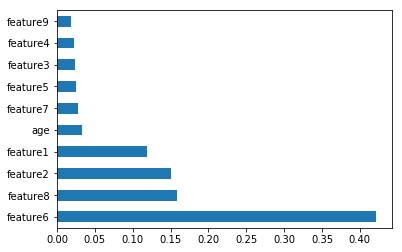

In [30]:

(pd.Series(last_alg.feature_importances_, index=['feature1', 'age', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'feature7', 'feature8', 'feature9'])
   .nlargest(10)
   .plot(kind='barh')) 
plt.show()

# feature6 больше всего влияет на модель

In [7]:
X1=X
X1['true']=y
X1['pred']=train_predictions
X1['prob']=train_predprob


In [8]:
valid['pred']=last_predictions
valid['prob']=last_predprob

In [10]:
X1.to_excel('train1.xlsx')

In [37]:
X.sort_values(by=['prob'],ascending=False).to_excel('train.xlsx')

In [60]:
valid.sort_values(by=['prob'], ascending=False)

,feature1,age,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,pred,prob
23254,1.000000,54,3,1718.000000,NaN,18,3,0,2,0.0,1,0.915141
16662,1.000000,61,4,921.000000,NaN,11,3,0,1,0.0,1,0.906263
1954,1.000000,55,3,1489.000000,NaN,5,3,0,1,0.0,1,0.893332
8353,1.000000,50,3,0.637594,6500.0,12,3,1,1,2.0,1,0.892853
18867,1.000000,48,4,10.163225,4600.0,16,1,2,2,1.0,1,0.892022
17125,1.000000,59,4,1375.000000,NaN,9,3,0,2,0.0,1,0.878601
29055,1.000000,45,4,10.673565,3188.0,5,3,1,1,0.0,1,0.874874
21540,1.000000,41,3,0.651415,3780.0,6,3,2,2,3.0,1,0.871095
10726,1.000000,40,3,0.651305,1800.0,6,3,0,1,3.0,1,0.868417
7694,1.000000,45,3,20.030194,5000.0,14,0,4,1,1.0,1,0.866934


In [11]:
valid.to_excel('test1.xlsx')